# Text Analysis

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

from utils.analysis_helpers import *
from utils.clusters_helpers import *

c:\Users\david\anaconda3\envs\basic\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Choose features of the data to analyse
- Drop or select specifics conditions
- Differentiate between interviwer & participant

In [4]:
directory = '../interviews_corrected/6_final/**/' 

df_all = load_and_combine_csv(directory)
df_all = standardize_data(df_all)
df_all = calculate_word_counts(df_all)

df_all.to_csv("outputs/combined_data.csv", index=False)

Found 82 CSV files.
Standardized speaker labels.
Normalized text in 'Content' column.
Calculated 'Word Count' for each 'Content' entry.


In [5]:
print(f"Unique conditions before filtering: {df_all['Condition'].unique()}")
print(f"Number of interviews before filtering: {df_all['File Name'].nunique()}")
# *0*: No "real" interview (e.g., setup phase, small talk). We filter these out.
df_all = df_all[df_all["Condition"] != 0]
print(f"Unique conditions after filtering: {df_all['Condition'].unique()}")
print(f"Number of interviews (File Name) after filtering: {df_all['File Name'].nunique()}")

Unique conditions before filtering: [1 'C' 'I' 0]
Number of interviews before filtering: 82
Unique conditions after filtering: [1 'C' 'I']
Number of interviews (File Name) after filtering: 75


In [6]:
# If only want to focus on participant speaker
df_participant = df_all[df_all["Speaker"] == "Participant"].copy()
df_interviewer = df_all[df_all["Speaker"] == "Interviewer"].copy()

## Word Count

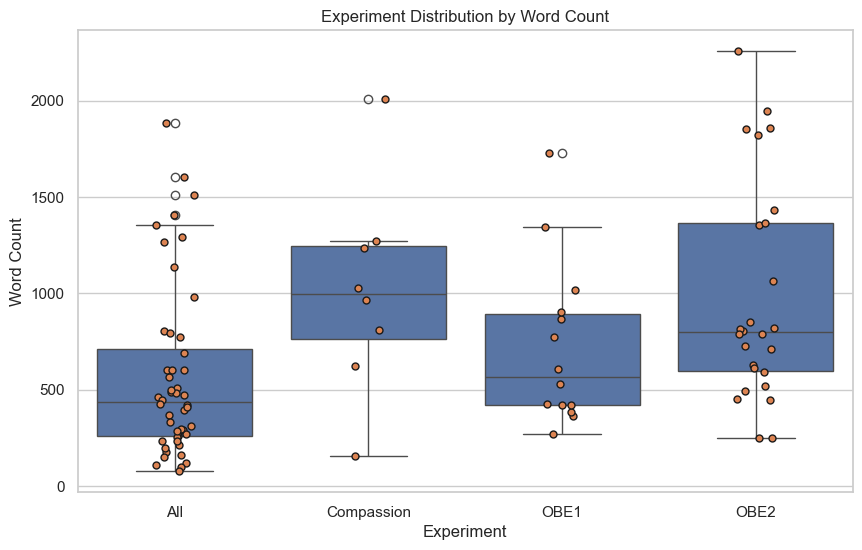

In [7]:
# Add a new row for the "All" category
df_word = aggregate_counts(df_participant,["Experiment","Id"]).copy()
df_word['Experiment'] = 'All'

# Concatenate the original data with the "All" data
df_combined = pd.concat([df_word,aggregate_counts(df_all,["Experiment","Id"])])

stripplot(df_combined, 'Experiment', 'Word Count')

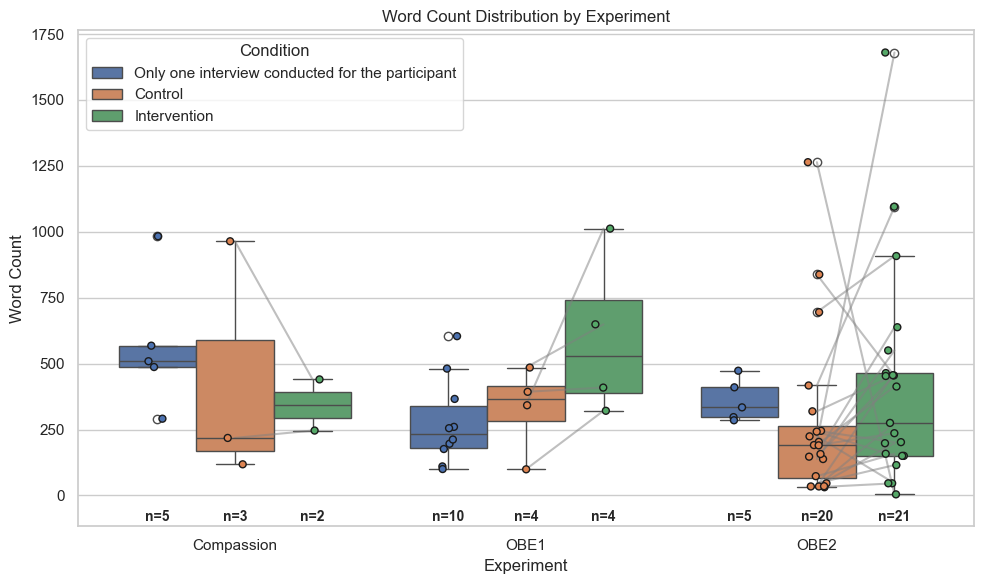

In [8]:
# Group by Id instead of File Name because the same participant can have the same condition in different interviews
stripplot_with_counts(aggregate_counts(df_participant, ['Experiment', "Id", "Condition"]), 'Experiment', 'Word Count', 
                      hue_column='Condition', id_column="Id", legend_labels=["Only one interview conducted for the participant","Control","Intervention"])#,file_name="stripplot_word_count_id.png")

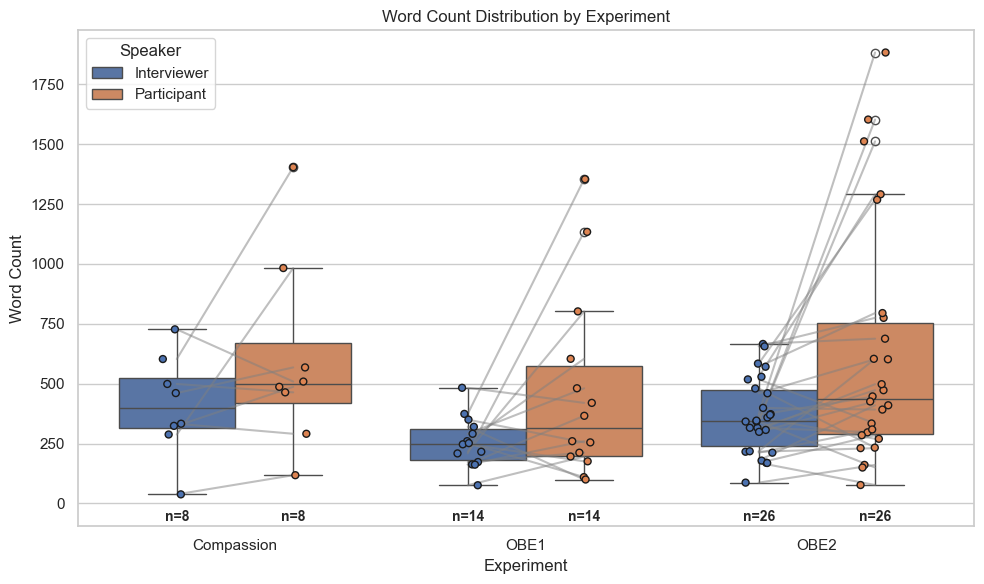

In [10]:
stripplot_with_counts(aggregate_counts(df_all, ['Experiment', "Id", 'Speaker']), 'Experiment', 'Word Count', hue_column='Speaker', id_column="Id")

## Interviewers Distribution

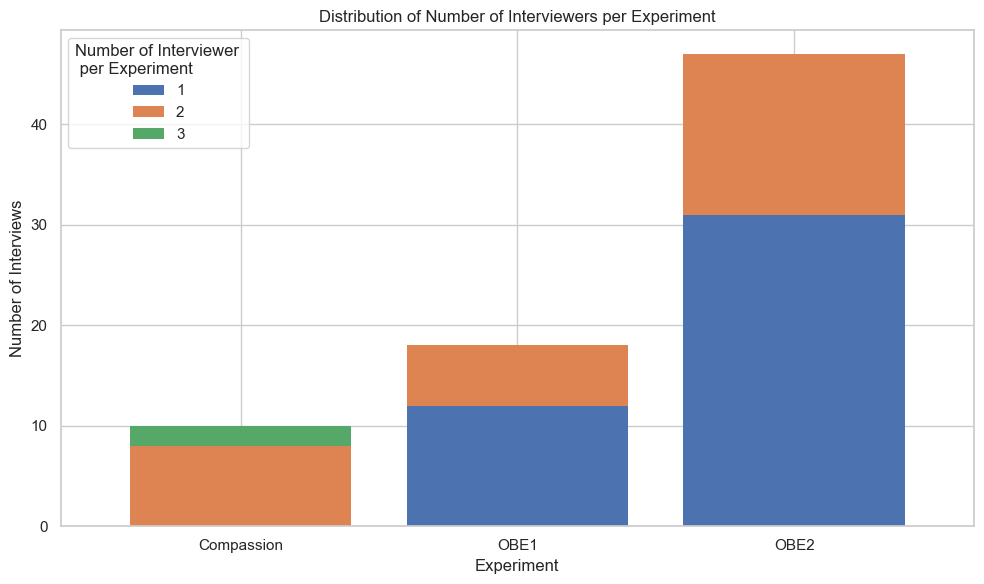

In [11]:
# Step 1: Drop participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count unique interviewers per interview
experimenter_count = (
    filtered_df.groupby(['Experiment', 'File Name'])['Speaker_original']
    .nunique()
    .reset_index()
)
experimenter_count.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Aggregate counts for each experiment and interviewer category
experiment_summary = experimenter_count.groupby(['Experiment', 'Number of Interviewers'])['File Name'].count().reset_index()
experiment_summary.rename(columns={'File Name': 'Count'}, inplace=True)

# Step 4: Ensure all categories are represented
categories = list(range(1, experimenter_count['Number of Interviewers'].max() + 1))  # 1, 2, 3, etc.
all_experiments = experiment_summary['Experiment'].unique()
full_summary = pd.DataFrame(
    [(experiment, category) for experiment in all_experiments for category in categories],
    columns=['Experiment', 'Number of Interviewers']
).merge(experiment_summary, on=['Experiment', 'Number of Interviewers'], how='left').fillna(0)

# Convert counts to integers for clarity
full_summary['Count'] = full_summary['Count'].astype(int)

# Convert the Number of Interviewers to string for grouped bar chart
full_summary['Number of Interviewers'] = full_summary['Number of Interviewers'].astype(str)

# Step 5: Stacked bar chart
stacked_data = full_summary.pivot(index='Experiment', columns='Number of Interviewers', values='Count').fillna(0)
stacked_data.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.8, linewidth=0)

# Add labels and title
plt.title("Distribution of Number of Interviewers per Experiment")
plt.ylabel("Number of Interviews")
plt.xlabel("Experiment")
plt.xticks(rotation=0)
plt.legend(title="Number of Interviewer \n per Experiment")

plt.tight_layout()
plt.show()

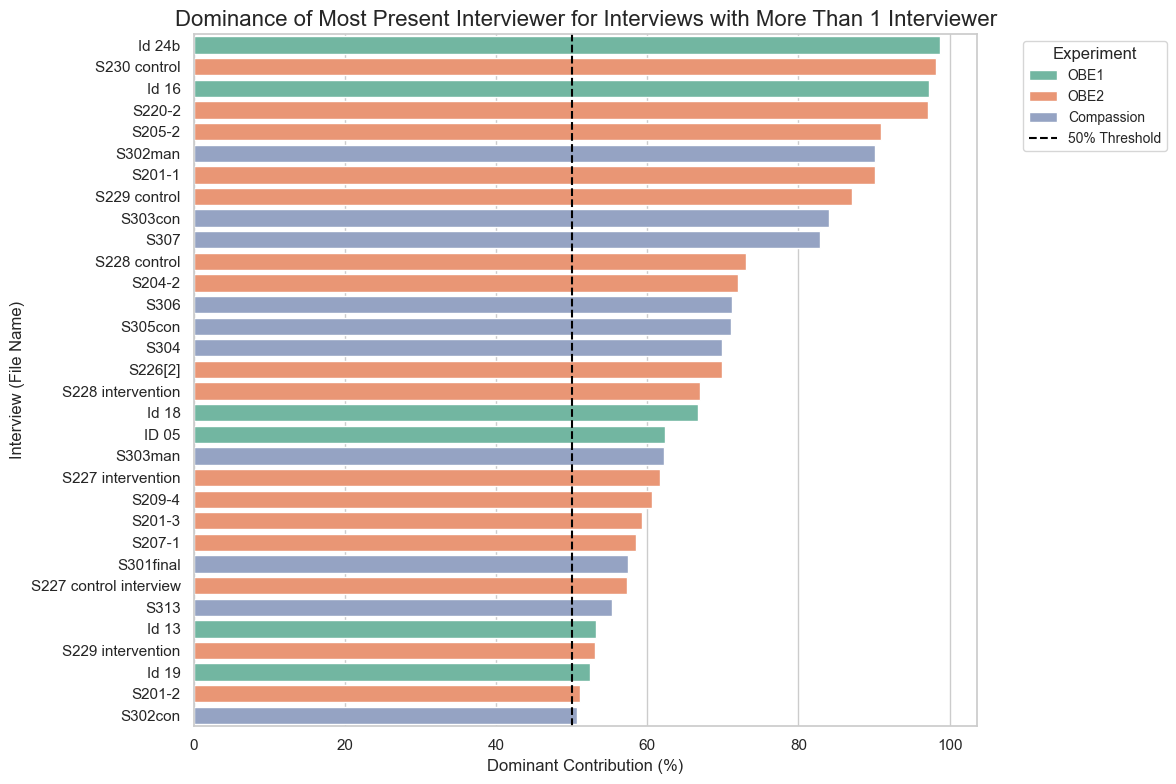

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Drop participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count unique interviewers per interview
experimenter_count = (
    filtered_df.groupby(['Experiment', 'File Name'])['Speaker_original']
    .nunique()
    .reset_index()
)
experimenter_count.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Filter for interviews with more than 1 interviewer
multi_interviewer_files = experimenter_count[experimenter_count['Number of Interviewers'] > 1]
filtered_df = filtered_df[filtered_df['File Name'].isin(multi_interviewer_files['File Name'])]

# Step 4: Calculate total word count per speaker per interview
word_distribution = filtered_df.groupby(['File Name', 'Speaker_original', 'Experiment'])['Word Count'].sum().reset_index()

# Step 5: Calculate dominance (largest contribution)
dominance = word_distribution.groupby(['File Name', 'Experiment'])['Word Count'].max().reset_index()
total_word_count = word_distribution.groupby(['File Name'])['Word Count'].sum().reset_index()
dominance = dominance.merge(total_word_count, on='File Name', how='left')
dominance['Dominance (%)'] = (dominance['Word Count_x'] / dominance['Word Count_y']) * 100
dominance.rename(columns={'Word Count_x': 'Max Contribution', 'Word Count_y': 'Total Words'}, inplace=True)

# Sort by dominance
dominance = dominance.sort_values(by='Dominance (%)', ascending=False)

# Step 6: Plot dominance for interviews with more than 1 interviewer
plt.figure(figsize=(12, 8))
sns.barplot(data=dominance, x='Dominance (%)', y='File Name', hue='Experiment', palette="Set2")

# Add a vertical line at 50% to highlight balance
plt.axvline(50, color='black', linestyle='--', label="50% Threshold")

# Add titles and labels
plt.title("Dominance of Most Present Interviewer for Interviews with More Than 1 Interviewer", fontsize=16)
plt.xlabel("Dominant Contribution (%)", fontsize=12)
plt.ylabel("Interview (File Name)", fontsize=12)
plt.legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [13]:
# Step 1: Filter out participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count the number of unique interviewers for each interview
interviewer_counts = (
    filtered_df.groupby(['Id', 'File Name'])['Speaker_original']
    .nunique()
    .reset_index()
)
interviewer_counts.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Check changes in the number of interviewers for each participant (ID)
participant_interviewer_changes = (
    interviewer_counts.groupby('Id')['Number of Interviewers']
    .nunique()
    .reset_index()
)
participant_interviewer_changes.rename(columns={'Number of Interviewers': 'Unique Interviewer Counts'}, inplace=True)

# Step 4: Identify participants with changes in interviewer counts across their interviews
participants_with_changes = participant_interviewer_changes[
    participant_interviewer_changes['Unique Interviewer Counts'] > 1
]

# Step 5: Display results
if participants_with_changes.empty:
    print("All participants have consistent numbers of interviewers across their interviews.")
else:
    print("The following participants have varying numbers of interviewers across their interviews:")
    print(participants_with_changes)

# Optional: Display detailed changes per ID
detailed_changes = interviewer_counts[interviewer_counts['Id'].isin(participants_with_changes['Id'])]
print("\nDetailed changes for inconsistent participants:")
print(detailed_changes.sort_values(by=['Id', 'File Name']))

The following participants have varying numbers of interviewers across their interviews:
     Id  Unique Interviewer Counts
3    13                          2
9    19                          2
13   24                          2
17  204                          2
18  205                          2
20  207                          2
22  209                          2
31  220                          2
39  230                          2
41  302                          2

Detailed changes for inconsistent participants:
     Id          File Name  Number of Interviewers
4    13              Id 13                       2
5    13             Id 13b                       1
11   19              Id 19                       2
12   19             Id 19b                       1
16   24              Id 24                       1
17   24             Id 24b                       2
23  204             S204-1                       1
24  204             S204-2                       2
25  205           

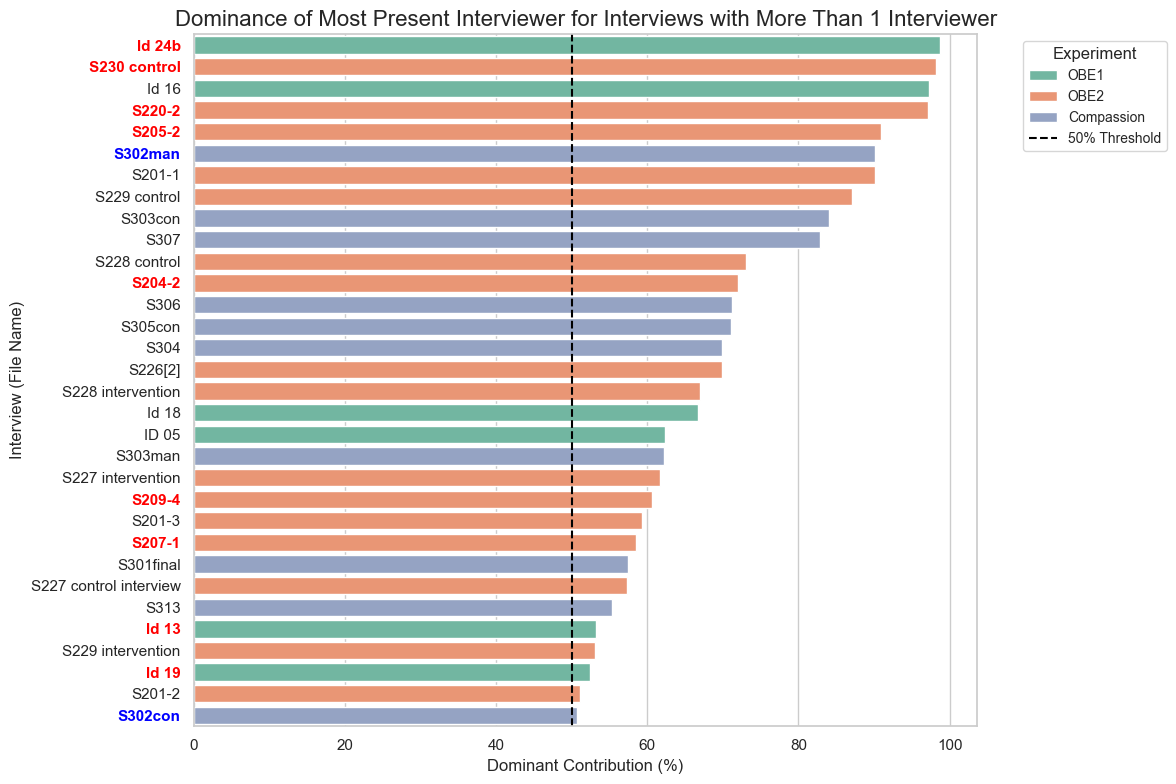

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Drop participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count unique interviewers per interview
experimenter_count = (
    filtered_df.groupby(['Experiment', 'File Name'])['Speaker_original']
    .nunique()
    .reset_index()
)
experimenter_count.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Filter for interviews with more than 1 interviewer
multi_interviewer_files = experimenter_count[experimenter_count['Number of Interviewers'] > 1]
filtered_df = filtered_df[filtered_df['File Name'].isin(multi_interviewer_files['File Name'])]

# Step 4: Calculate total word count per speaker per interview
word_distribution = filtered_df.groupby(['File Name', 'Speaker_original', 'Experiment'])['Word Count'].sum().reset_index()

# Step 5: Calculate dominance (largest contribution)
dominance = word_distribution.groupby(['File Name', 'Experiment'])['Word Count'].max().reset_index()
total_word_count = word_distribution.groupby(['File Name'])['Word Count'].sum().reset_index()
dominance = dominance.merge(total_word_count, on='File Name', how='left')
dominance['Dominance (%)'] = (dominance['Word Count_x'] / dominance['Word Count_y']) * 100
dominance.rename(columns={'Word Count_x': 'Max Contribution', 'Word Count_y': 'Total Words'}, inplace=True)

# Sort by dominance
dominance = dominance.sort_values(by='Dominance (%)', ascending=False)

# Step 6: Identify interviews to highlight
inconsistent_interviews = detailed_changes['File Name'].unique()  # From earlier inconsistent participant analysis
special_case = 'S302'  # Special case to highlight differently

# Step 7: Plot dominance for interviews with more than 1 interviewer
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=dominance, x='Dominance (%)', y='File Name', hue='Experiment', palette="Set2")

# Add a vertical line at 50% to highlight balance
plt.axvline(50, color='black', linestyle='--', label="50% Threshold")

# Customize y-axis tick labels
for tick, label in zip(barplot.get_yticks(), barplot.get_yticklabels()):
    file_name = label.get_text()
    if file_name in inconsistent_interviews and special_case not in file_name :
        label.set_color('red')  # Highlight inconsistent interviews in red
        label.set_fontweight('bold')
    elif special_case in file_name:
        label.set_color('blue')  # Highlight the special case in blue
        label.set_fontweight('bold')

# Add titles and labels
plt.title("Dominance of Most Present Interviewer for Interviews with More Than 1 Interviewer", fontsize=16)
plt.xlabel("Dominant Contribution (%)", fontsize=12)
plt.ylabel("Interview (File Name)", fontsize=12)
plt.legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


<Figure size 1200x600 with 0 Axes>

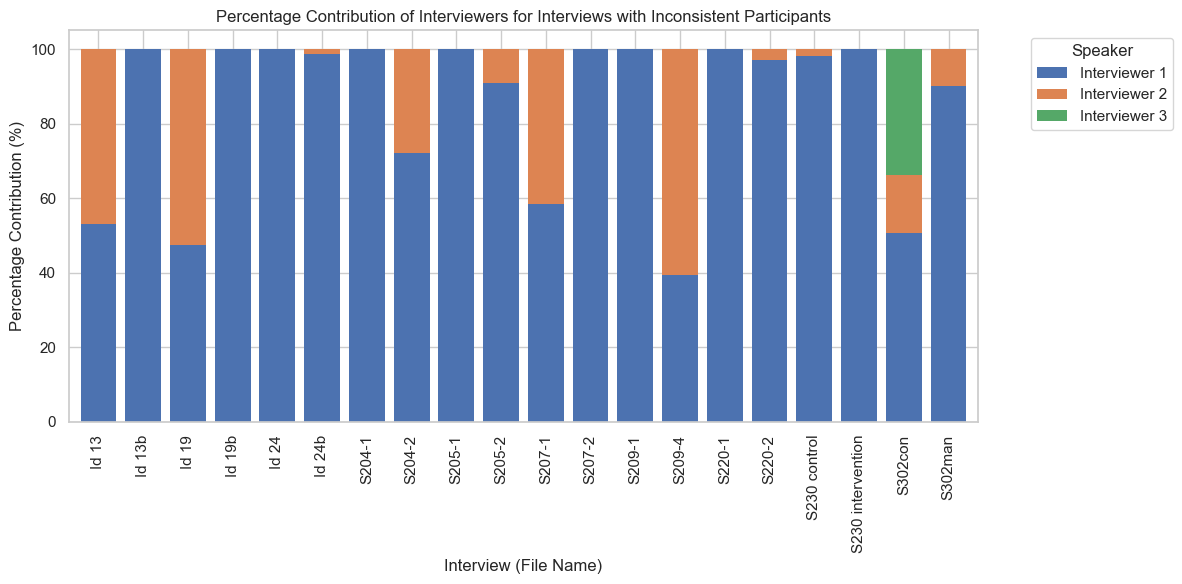

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter out participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count the number of unique interviewers for each interview
interviewer_counts = (
    filtered_df.groupby(['Id', 'File Name'])['Speaker_original']
    .nunique()
    .reset_index()
)
interviewer_counts.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Check changes in the number of interviewers for each participant (ID)
participant_interviewer_changes = (
    interviewer_counts.groupby('Id')['Number of Interviewers']
    .nunique()
    .reset_index()
)
participant_interviewer_changes.rename(columns={'Number of Interviewers': 'Unique Interviewer Counts'}, inplace=True)

# Step 4: Identify participants with changes in interviewer counts across their interviews
participants_with_changes = participant_interviewer_changes[
    participant_interviewer_changes['Unique Interviewer Counts'] > 1
]

# Step 5: Filter detailed changes for inconsistent participants
detailed_changes = interviewer_counts[interviewer_counts['Id'].isin(participants_with_changes['Id'])]

# Step 6: Filter the main DataFrame for inconsistent participants
inconsistent_interviews = filtered_df[filtered_df['Id'].isin(participants_with_changes['Id'])]

# Step 7: Calculate total word count per speaker per interview
word_distribution = inconsistent_interviews.groupby(['File Name', 'Speaker_original'])['Word Count'].sum().reset_index()

# Step 8: Calculate total word count per interview
total_words_per_interview = word_distribution.groupby('File Name')['Word Count'].sum().reset_index()
total_words_per_interview.rename(columns={'Word Count': 'Total Words'}, inplace=True)

# Step 9: Merge total word counts to calculate percentages
word_distribution = word_distribution.merge(total_words_per_interview, on='File Name')
word_distribution['Percentage'] = (word_distribution['Word Count'] / word_distribution['Total Words']) * 100

# Step 10: Pivot to create a DataFrame with rows as interviews and columns as speakers
word_distribution_pivot = word_distribution.pivot(index='File Name', columns='Speaker_original', values='Percentage').fillna(0)

# Step 11: Plot stacked bar chart for inconsistent interviews
plt.figure(figsize=(12, 6))
word_distribution_pivot.plot(kind="bar", stacked=True, figsize=(12, 6), width=0.8, linewidth=0)

# Add titles and labels
plt.title("Percentage Contribution of Interviewers for Interviews with Inconsistent Participants")
plt.xlabel("Interview (File Name)")
plt.ylabel("Percentage Contribution (%)")
plt.xticks(rotation=90, ha="center")
plt.legend(title="Speaker", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Display the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

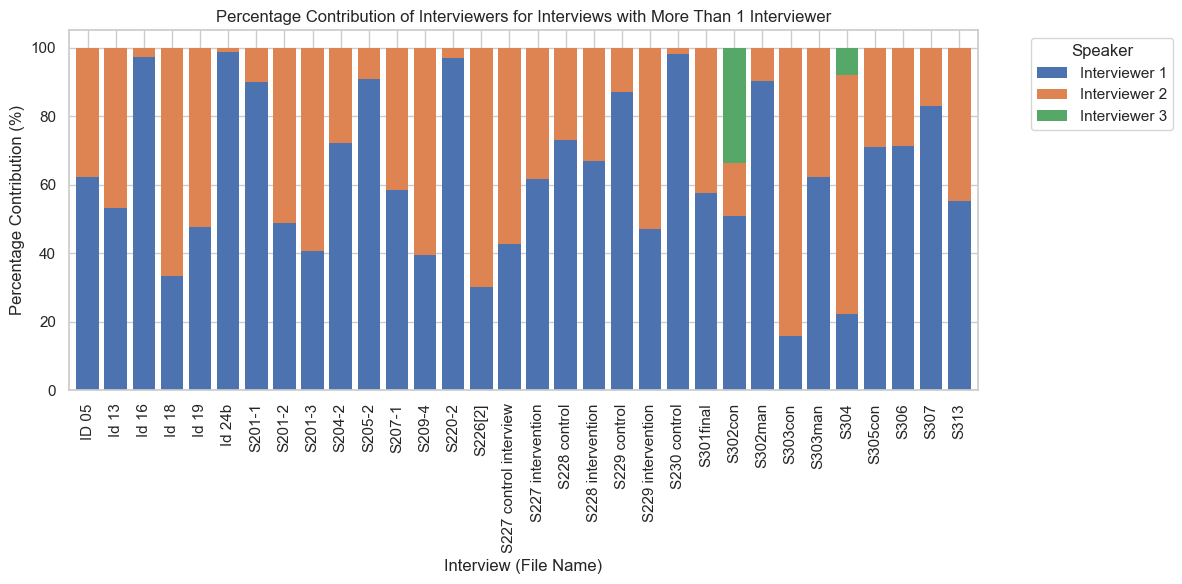

In [16]:
# Step 1: Filter out participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count unique interviewers per interview and filter for interviews with more than 1 interviewer
experimenter_count = (
    filtered_df.groupby(['File Name'])['Speaker_original']
    .nunique()
    .reset_index()
)
experimenter_count.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Filter for interviews with more than 1 interviewer
multi_interviewer_files = experimenter_count[experimenter_count['Number of Interviewers'] > 1]['File Name']
filtered_df = filtered_df[filtered_df['File Name'].isin(multi_interviewer_files)]

# Step 4: Calculate total word count per speaker per interview
word_distribution = filtered_df.groupby(['File Name', 'Speaker_original'])['Word Count'].sum().reset_index()

# Step 5: Calculate total word count per interview
total_words_per_interview = word_distribution.groupby('File Name')['Word Count'].sum().reset_index()
total_words_per_interview.rename(columns={'Word Count': 'Total Words'}, inplace=True)

# Step 6: Merge total word counts to calculate percentages
word_distribution = word_distribution.merge(total_words_per_interview, on='File Name')
word_distribution['Percentage'] = (word_distribution['Word Count'] / word_distribution['Total Words']) * 100

# Step 7: Pivot to create a DataFrame with rows as interviews and columns as speakers
word_distribution_pivot = word_distribution.pivot(index='File Name', columns='Speaker_original', values='Percentage').fillna(0)

# Step 8: Plot stacked bar chart for interviews with more than 1 interviewer
plt.figure(figsize=(12, 6))
word_distribution_pivot.plot(kind="bar", stacked=True, figsize=(12, 6), width=0.8,linewidth=0)

# Add titles and labels
plt.title("Percentage Contribution of Interviewers for Interviews with More Than 1 Interviewer")
plt.xlabel("Interview (File Name)")
plt.ylabel("Percentage Contribution (%)")
plt.xticks(rotation=90, ha="center")
plt.legend(title="Speaker", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Display the plot
plt.show()

## Frequency & Unique Words

In [10]:
extra_words = ["yeah", "like", "think", "know", "dont","yes", "one","okay","mm", "really","bit","could","thats","see","feel","felt"] 

df_participant['preprocessed_content'] = df_participant['Content'].apply(lambda x: preprocess_text(x, extra_stopwords=extra_words))

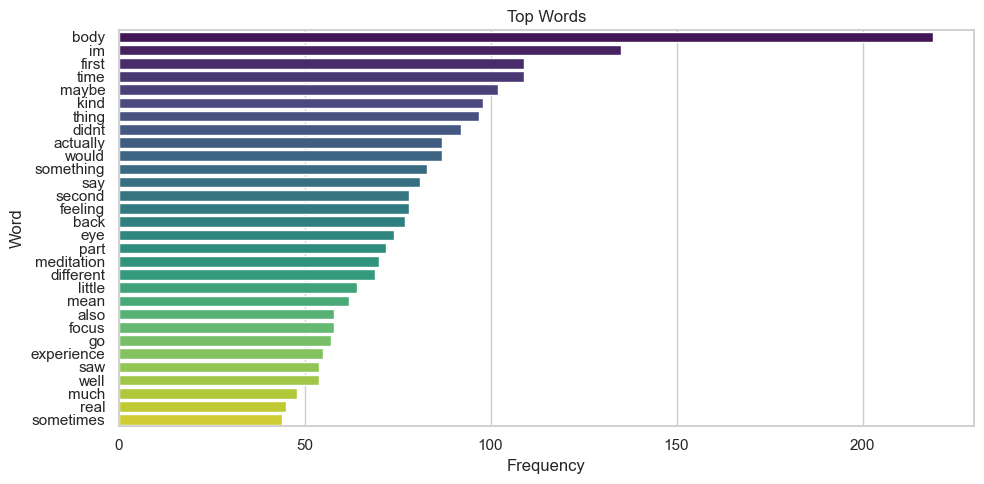

In [11]:
word_frequency_analysis(df_participant, top_n=30) #groupby_column=["Experiment"])

In [12]:
# You can specify any list of columns for grouping, e.g., ['Experiment', 'Condition']
unique_words_df_participant = count_unique_words(df_participant, groupby_columns=['Experiment', 'Condition'])
unique_words_df_participant = unique_words_df_participant.sort_values(by='Participant_Count', ascending=False)
unique_words_df_participant.to_csv("outputs/unique_words_participant.csv", index=False)

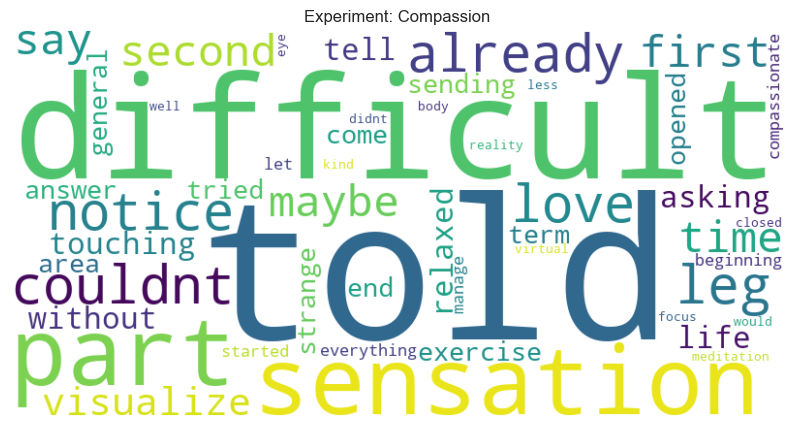

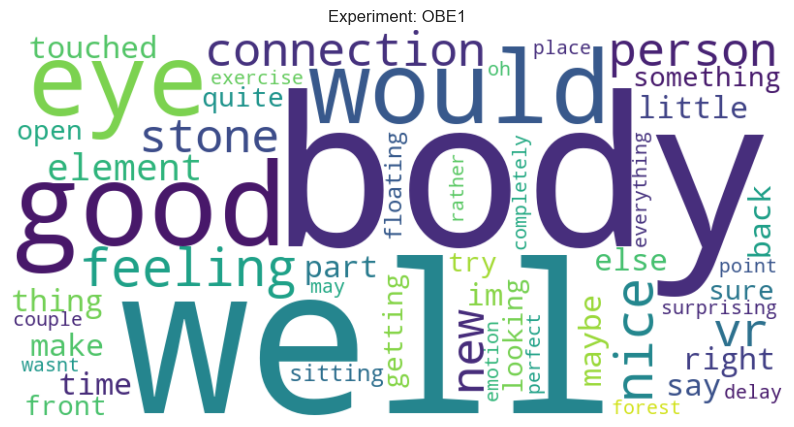

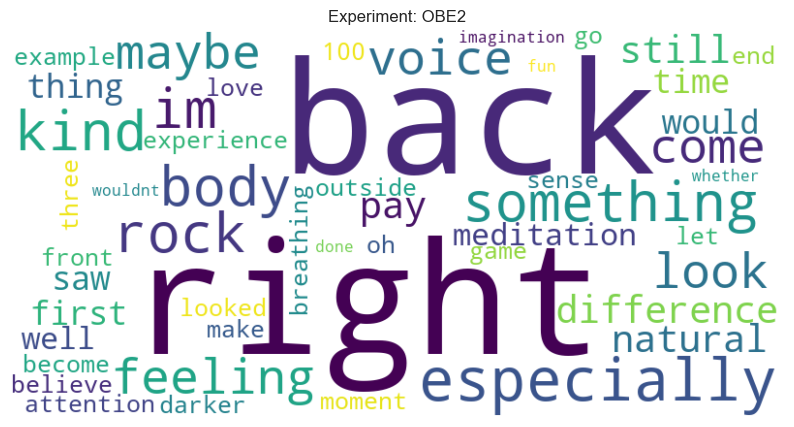

In [13]:
generate_word_clouds(unique_words_df_participant, groupby_columns=['Experiment'])

## Clusters

In [14]:
#df = df_all[df_all["Speaker"] == "Interviewer"].copy()
df = df_all[df_all["Speaker"] == "Participant"].copy()

# I want to select only one experiment
df = df[df["Experiment"] == "OBE2"]

In [15]:
# Define extra stopwords
extra_stopwords = {'yeah', 'yes', 'like', 'you', 'know', 'um', 'uh', 'dont', 'really'}

# Preprocess the text
df['preprocessed_content'] = df['Content'].apply(
    lambda x: preprocess_text(x, extra_stopwords=None, ngrams=2)
)

grouped_df = df.groupby('Id').agg({
    'preprocessed_content': ' '.join,  # Combine preprocessed text
    'Experiment': 'first',             # Keep the first (consistent if File Name is unique)         
}).reset_index()

In [16]:
grouped_df

,Id,preprocessed_content,Experiment
0,201,beginning_control control_put put_attention at...,OBE2
1,202,interesting_feel feel_outside outside_mind y...,OBE2
2,203,feeling_body body_touch touch_body body_see se...,OBE2
3,204,okay_creepy observing_body body_seeing seeing...,OBE2
4,205,yes_yes yes_super super_nice really_relaxing w...,OBE2
5,206,feel_sleepy think_beginning beginning_certain ...,OBE2
6,207,part_could could_see see_body body_back back_b...,OBE2
7,208,actually_noticed noticed_there unless_go go_s...,OBE2
8,209,moment_feel feel_mismatch yeah_thinking think...,OBE2
9,210,yeah_really really_nice really_like like_also ...,OBE2


In [17]:
embeddings_tf = embed_text_tfidf(grouped_df['preprocessed_content'].tolist())  # For TF-IDF
embeddings_bert = embed_text_bert(grouped_df['preprocessed_content'].tolist())  # For BERT

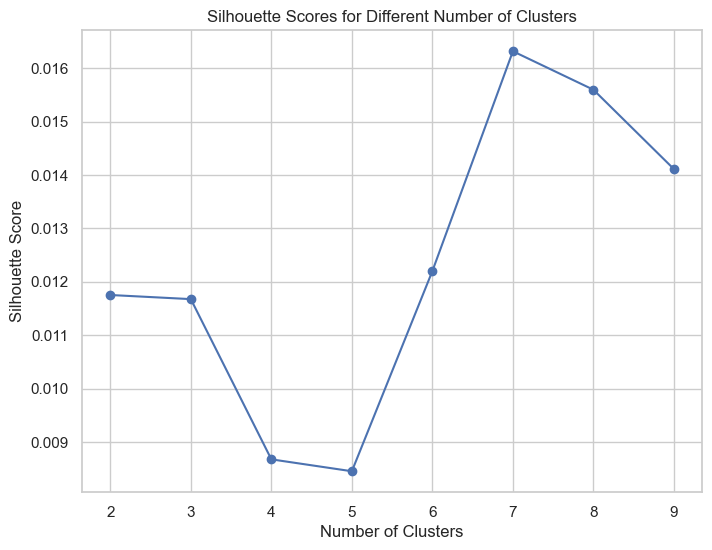

Optimal number of clusters: 7


In [18]:
find_optimal_clusters(embeddings_tf)

In [19]:
cluster_labels, kmeans_model = cluster_text_kmeans(embeddings_tf, 2)

df_tf = grouped_df.copy()
df_tf['Cluster'] = cluster_labels
df_tf["Embedding"] = embeddings_tf.tolist()

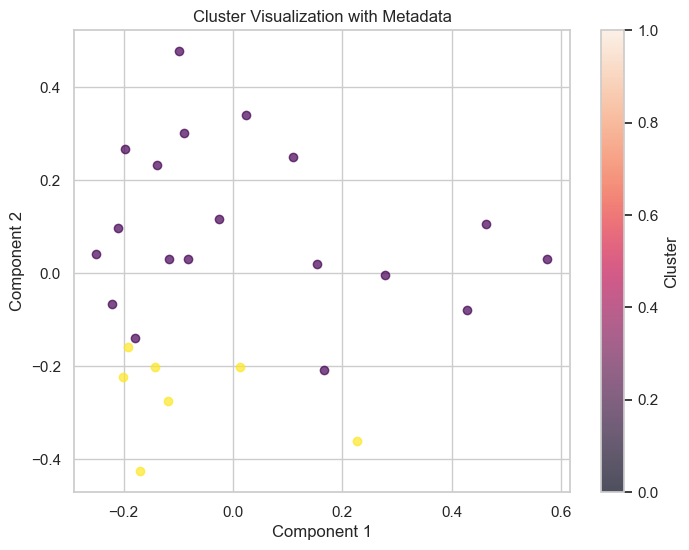

In [20]:
visualize_clusters_from_df(
    df=df_tf,
    n_components=2,
)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

def visualize_metadata_distribution(
    df: pd.DataFrame,
    cluster_col: str = 'Cluster',
    metadata_cols: List[str] = [],
    title_prefix: str = 'Metadata Distribution by Cluster'
):
    """
    Visualizes the distribution of selected metadata columns across clusters.

    Parameters:
    - df (pd.DataFrame): DataFrame containing clusters and metadata.
    - cluster_col (str): Column name for cluster labels (default: 'Cluster').
    - metadata_cols (List[str]): List of metadata column names to visualize.
    - title_prefix (str): Prefix for the plot titles.

    Output:
    - Displays a bar plot for each metadata column showing its distribution by cluster.
    """
    # Check if cluster column exists
    if cluster_col not in df.columns:
        raise ValueError(f"'{cluster_col}' column not found in the DataFrame.")

    # Check if metadata columns exist
    missing_cols = [col for col in metadata_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"The following metadata columns are missing: {', '.join(missing_cols)}")

    # Iterate over metadata columns and plot
    for meta_col in metadata_cols:
        # Group data by cluster and metadata column
        grouped = df.groupby([cluster_col, meta_col]).size().reset_index(name='Count')

        # Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=grouped,
            x=cluster_col,
            y='Count',
            hue=meta_col,
            palette='viridis'
        )
        plt.title(f'{title_prefix}: {meta_col}')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.legend(title=meta_col, loc='upper right')
        plt.show()


In [22]:
visualize_metadata_distribution(df_tf, metadata_cols=['Condition', 'Experiment'])

ValueError: The following metadata columns are missing: Condition

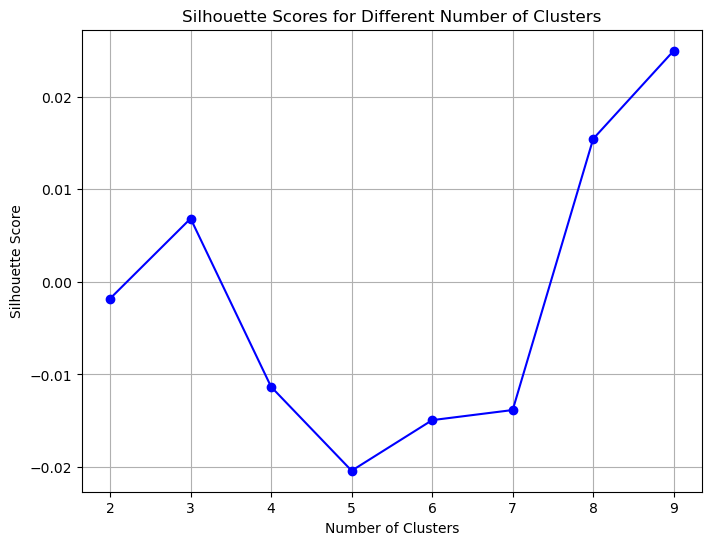

Optimal number of clusters: 9


In [ ]:
find_optimal_clusters(embeddings_bert)

In [ ]:
cluster_labels, kmeans_model = cluster_text_kmeans(embeddings_bert, 2)

df_bert = grouped_df.copy()
df_bert['Cluster'] = cluster_labels
df_bert["Embedding"] = embeddings_bert.tolist()

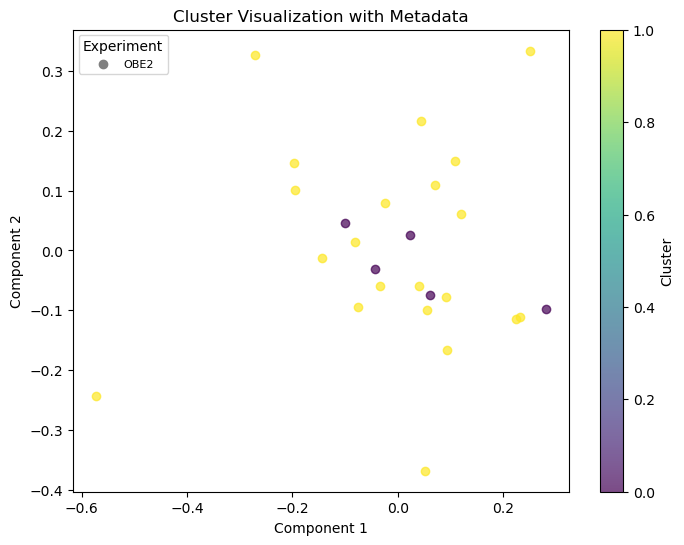

In [ ]:
visualize_clusters_from_df(
    df=df_bert,
    shape_by='Experiment',  # Optional
    n_components=2,
)

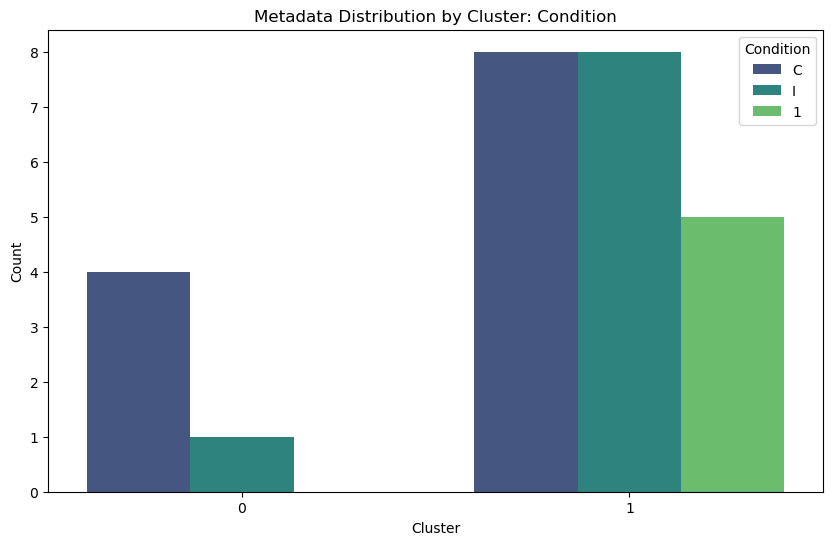

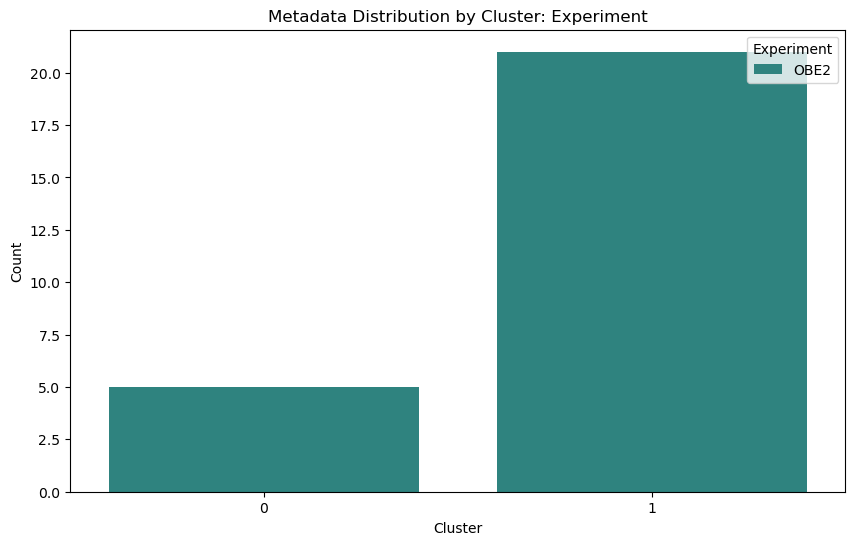

In [ ]:
visualize_metadata_distribution(df_bert, metadata_cols=['Condition', 'Experiment'])

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

# Perform DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
labels = dbscan.fit_predict(embeddings_tf)

# Identify noise points (-1)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters: {num_clusters}")


Number of clusters: 0
